In [ ]:
!nvidia-smi


Wed Jan 14 17:08:35 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.105.07             Driver Version: 581.80         CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3080        On  |   00000000:01:00.0  On |                  N/A |
| 53%   40C    P2             94W /  340W |    9630MiB /  10240MiB |      3%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
!pip -q install text2vec==1.3.7 scikit-learn openpyxl pandas numpy tqdm

In [ ]:
!pip -q install text2vec==1.3.7 scikit-learn openpyxl pandas numpy tqdm xgboost


In [ ]:
!pip install -U transformers datasets accelerate


In [ ]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier




In [ ]:
PIPELINE = "simcse_svm"
# 可选：
# "tfidf_lr"     : TF-IDF + LogisticRegression
# "simcse_svm"   : SimCSE + LinearSVC
# "simcse_xgb"   : SimCSE + XGBoost（GPU）
# "bert_roberta" : RoBERTa
TEXT_COL  = "text"
LABEL_COL = "final_label"

In [ ]:
!free -h

               total        used        free      shared  buff/cache   available
Mem:            11Gi       5.4Gi       4.7Gi       249Mi       1.6Gi       5.8Gi
Swap:          4.0Gi       3.0Gi       1.0Gi


In [ ]:
print("Files in /content:", os.listdir("/content"))

Files in /content: ['bert_output', 'checkpoints', 'modle对比.xlsx', 'simhei.ttf', 'test_human_400.xlsx', 'test_llm_1200.xlsx', 'train_llm_4800.xlsx']


In [ ]:
TRAIN_FILE = "/content/train_llm_4800.xlsx"
TEST_FILES = {
    "test_llm_1200":   "/content/test_llm_1200.xlsx",
    "test_human_400":  "/content/test_human_400.xlsx",
}

assert os.path.exists(TRAIN_FILE), f"找不到: {TRAIN_FILE}"
for name, path in TEST_FILES.items():
    assert os.path.exists(path), f"找不到: {path}"

In [ ]:
# 读取与清洗
def clean_df(df):
    df = df.copy()
    df[TEXT_COL]  = df[TEXT_COL].astype(str).str.strip()
    df[LABEL_COL] = df[LABEL_COL].astype(str).str.strip()
    df = df.dropna(subset=[TEXT_COL, LABEL_COL])
    df = df[(df[TEXT_COL] != "") & (df[LABEL_COL] != "")]
    return df

df_train = clean_df(pd.read_excel(TRAIN_FILE))
test_dfs = {name: clean_df(pd.read_excel(path)) for name, path in TEST_FILES.items()}


In [ ]:
#标签编码
le = LabelEncoder()
le.fit(df_train[LABEL_COL].values)

X_train_text = df_train[TEXT_COL].tolist()
y_train      = le.transform(df_train[LABEL_COL].values)

print("Train:", len(X_train_text))
print("Classes:", list(le.classes_))
for name, df in test_dfs.items():
    print(name, ":", len(df))

Train: 4790
Classes: ['neg', 'neu', 'pos']
test_llm_1200 : 1203
test_human_400 : 396


In [ ]:
#保存模型的评估结果
RESULTS_STORE = {}
LAST_RUN_TITLE = None

In [ ]:
#统一评估函数
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def evaluate_on_tests(predict_fn, title):
    global RESULTS_STORE, LAST_RUN_TITLE

    results = {}
    for name, df in test_dfs.items():
        X_test_text = df[TEXT_COL].tolist()
        y_test = le.transform(df[LABEL_COL].values)
        y_pred = predict_fn(X_test_text)

        print("\n" + "="*70)
        print(f"[{title}]  EVAL ON: {name}")
        print("Accuracy:", accuracy_score(y_test, y_pred))
        print(classification_report(y_test, y_pred, target_names=le.classes_, digits=4))
        print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

        results[name] = {"y_test": y_test, "y_pred": y_pred}


    RESULTS_STORE[title] = results
    LAST_RUN_TITLE = title

    return results

In [ ]:
#TF-IDF + LR
def run_tfidf_lr():
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.linear_model import LogisticRegression

    tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=50000, min_df=2)
    X_train_tfidf = tfidf.fit_transform(X_train_text)

    clf = LogisticRegression(max_iter=2000, class_weight="balanced", n_jobs=12)
    clf.fit(X_train_tfidf, y_train)

    def predict_fn(test_texts):
        X_test_tfidf = tfidf.transform(test_texts)
        return clf.predict(X_test_tfidf)

    evaluate_on_tests(predict_fn, "TFIDF+LR")

In [ ]:
#SimCSE + SVM/XGB
_simcse_model = None
_X_train_simcse = None

def get_simcse_train_embeddings():
    """
    为了不重复算：只在第一次需要时算一次 train embedding
    """
    global _simcse_model, _X_train_simcse
    if _X_train_simcse is not None:
        return _X_train_simcse

    import numpy as np
    from tqdm import tqdm
    from text2vec import SentenceModel

    MODEL_NAME = "cyclone/simcse-chinese-roberta-wwm-ext"
    _simcse_model = SentenceModel(MODEL_NAME)

    def embed_texts(text_list, batch_size=64):
        embs = []
        for i in tqdm(range(0, len(text_list), batch_size), desc="Embedding(train)"):
            batch = text_list[i:i+batch_size]
            vecs = _simcse_model.encode(batch, show_progress_bar=False, batch_size=batch_size)
            embs.append(np.asarray(vecs))
        return np.vstack(embs)

    _X_train_simcse = embed_texts(X_train_text, batch_size=64)
    return _X_train_simcse

def simcse_encode(text_list, batch_size=64):
    import numpy as np
    from tqdm import tqdm
    assert _simcse_model is not None, "SimCSE model not initialized. Call get_simcse_train_embeddings() first."

    embs = []
    for i in tqdm(range(0, len(text_list), batch_size), desc="Embedding(test)"):
        batch = text_list[i:i+batch_size]
        vecs = _simcse_model.encode(batch, show_progress_bar=False, batch_size=batch_size)
        embs.append(np.asarray(vecs))
    return np.vstack(embs)

def run_simcse_svm():
    from sklearn.svm import LinearSVC

    X_train = get_simcse_train_embeddings()
    clf = LinearSVC(C=1.0, class_weight="balanced", random_state=42)
    clf.fit(X_train, y_train)

    def predict_fn(test_texts):
        X_test = simcse_encode(test_texts, batch_size=64)
        return clf.predict(X_test)

    evaluate_on_tests(predict_fn, "SimCSE+SVM")

def run_simcse_xgb():
    from xgboost import XGBClassifier

    X_train = get_simcse_train_embeddings()
    clf = XGBClassifier(
        n_estimators=400,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        tree_method="hist",
        device="cuda",
        objective="multi:softmax",
        num_class=len(le.classes_)
    )
    clf.fit(X_train, y_train)

    def predict_fn(test_texts):
        X_test = simcse_encode(test_texts, batch_size=64)
        return clf.predict(X_test)

    evaluate_on_tests(predict_fn, "SimCSE+XGB")




In [ ]:
#CRoBERTa


if PIPELINE == "bert_roberta":

    import torch
    import numpy as np
    from transformers import AutoTokenizer, AutoModel
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("Device:", device)

    model_name = "hfl/chinese-roberta-wwm-ext"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    bert = AutoModel.from_pretrained(model_name).to(device)
    bert.eval()   #


    def encode(texts, batch_size=32):
        all_vecs = []
        with torch.no_grad():
            for i in range(0, len(texts), batch_size):
                batch = texts[i:i+batch_size]
                inputs = tokenizer(
                    batch,
                    padding=True,
                    truncation=True,
                    max_length=128,
                    return_tensors="pt"
                ).to(device)

                outputs = bert(**inputs)
                cls_vec = outputs.last_hidden_state[:, 0, :]  # CLS
                all_vecs.append(cls_vec.cpu().numpy())

        return np.vstack(all_vecs)


    print("Encoding train...")
    X_train_vec = encode(X_train_text)

    clf = LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        n_jobs=12
    )
    clf.fit(X_train_vec, y_train)


    def predict_fn(test_texts):
        X_test_vec = encode(test_texts)
        return clf.predict(X_test_vec)


    evaluate_on_tests(predict_fn, "CRoBERTa + LR")



In [ ]:
def run_selected(p):
    if p == "tfidf_lr":
        run_tfidf_lr()
    elif p == "simcse_svm":
        run_simcse_svm()
    elif p == "simcse_xgb":
        run_simcse_xgb()
    elif p == "bert_roberta":

        pass
    elif p == "all":
        run_tfidf_lr()
        run_simcse_svm()
        run_simcse_xgb()

    else:
        raise ValueError(f"Unknown PIPELINE: {p}")

run_selected(PIPELINE)


Embedding(test): 100%|██████████| 19/19 [00:03<00:00,  6.16it/s]



[SimCSE+SVM]  EVAL ON: test_llm_1200
Accuracy: 0.7855361596009975
              precision    recall  f1-score   support

         neg     0.8638    0.8396    0.8515       642
         neu     0.6364    0.6920    0.6630       263
         pos     0.7645    0.7517    0.7580       298

    accuracy                         0.7855      1203
   macro avg     0.7549    0.7611    0.7575      1203
weighted avg     0.7895    0.7855    0.7871      1203

Confusion matrix:
 [[539  72  31]
 [ 43 182  38]
 [ 42  32 224]]


Embedding(test): 100%|██████████| 7/7 [00:00<00:00,  7.70it/s]


[SimCSE+SVM]  EVAL ON: test_human_400
Accuracy: 0.7676767676767676
              precision    recall  f1-score   support

         neg     0.8505    0.8376    0.8440       197
         neu     0.6458    0.5905    0.6169       105
         pos     0.7264    0.8191    0.7700        94

    accuracy                         0.7677       396
   macro avg     0.7409    0.7491    0.7436       396
weighted avg     0.7668    0.7677    0.7662       396

Confusion matrix:
 [[165  22  10]
 [ 24  62  19]
 [  5  12  77]]


In [ ]:
curr = RESULTS_STORE[LAST_RUN_TITLE]
y_test = curr["test_human_400"]["y_test"]
y_pred = curr["test_human_400"]["y_pred"]
print("Using model:", LAST_RUN_TITLE)


Using model: SimCSE+SVM


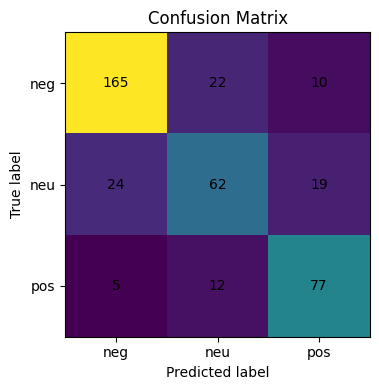

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

labels = ["neg", "neu", "pos"]
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 4))
plt.imshow(cm)
plt.xticks(range(3), labels)
plt.yticks(range(3), labels)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix")

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.tight_layout()
plt.show()


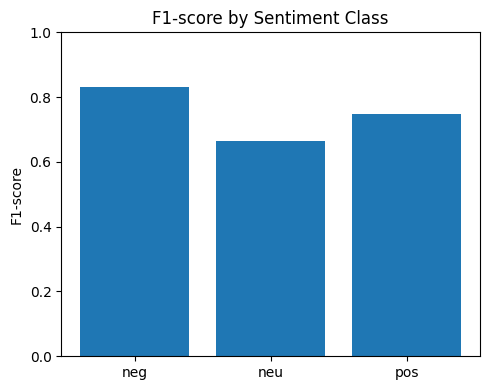

In [ ]:
labels = ["neg", "neu", "pos"]
f1_scores = [0.8324, 0.6656, 0.7470]

plt.figure(figsize=(5, 4))
plt.bar(labels, f1_scores)
plt.ylim(0, 1)
plt.ylabel("F1-score")
plt.title("F1-score by Sentiment Class")

plt.tight_layout()
plt.show()


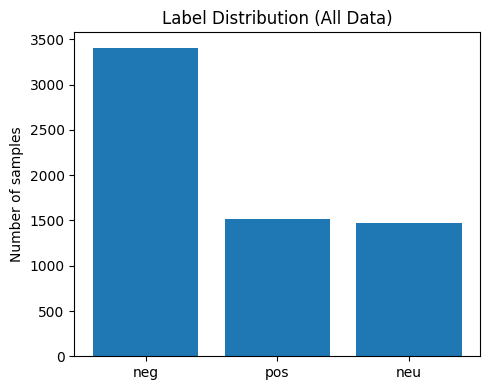

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

df_all = pd.concat(
    [df_train, test_dfs["test_llm_1200"], test_dfs["test_human_400"]],
    ignore_index=True
)

counts = df_all["final_label"].value_counts()

plt.figure(figsize=(5, 4))
plt.bar(counts.index, counts.values)
plt.ylabel("Number of samples")
plt.title("Label Distribution (All Data)")
plt.tight_layout()
plt.show()


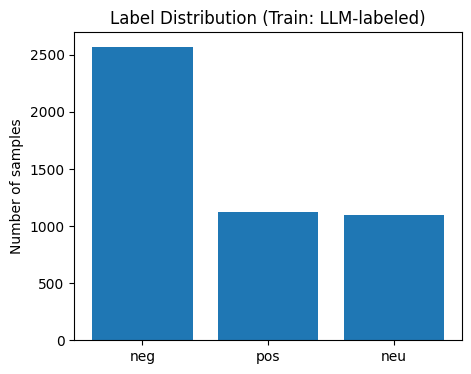

In [ ]:
counts = df_train["final_label"].value_counts()

plt.figure(figsize=(5, 4))
plt.bar(counts.index, counts.values)
plt.ylabel("Number of samples")
plt.title("Label Distribution (Train: LLM-labeled)")
plt.show()


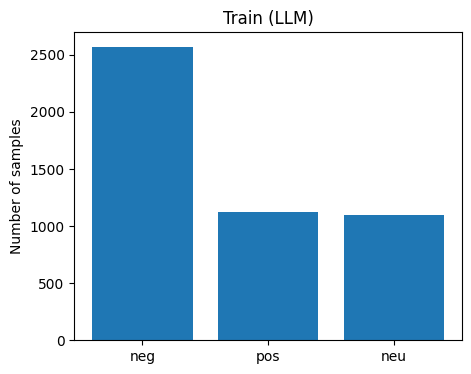

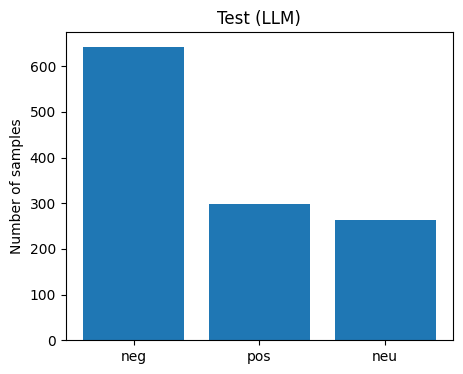

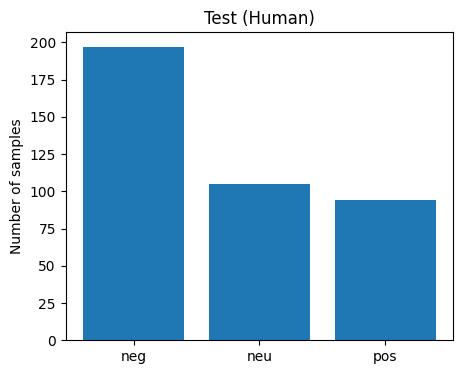

In [ ]:
def plot_dist(df, title):
    counts = df["final_label"].value_counts()
    plt.figure(figsize=(5, 4))
    plt.bar(counts.index, counts.values)
    plt.title(title)
    plt.ylabel("Number of samples")
    plt.show()

plot_dist(df_train, "Train (LLM)")
plot_dist(test_dfs["test_llm_1200"], "Test (LLM)")
plot_dist(test_dfs["test_human_400"], "Test (Human)")


In [ ]:
import pandas as pd

def evaluate_on_tests(predict_fn, title: str):
    results = {}
    for name, df in test_dfs.items():
        X_test_text = df[TEXT_COL].tolist()
        y_test = le.transform(df[LABEL_COL].values)
        y_pred = predict_fn(X_test_text)

        print("\n" + "="*70)
        print(f"[{title}]  EVAL ON: {name}")


        results[name] = (y_test, y_pred)
    return results


In [ ]:
print("LAST_RUN_TITLE =", LAST_RUN_TITLE)
print("RESULTS_STORE keys =", list(RESULTS_STORE.keys()))


LAST_RUN_TITLE = SimCSE+SVM
RESULTS_STORE keys = ['SimCSE+SVM']


In [ ]:
run_selected(PIPELINE)
curr = RESULTS_STORE[LAST_RUN_TITLE]
y_test = curr["test_human_400"]["y_test"]
y_pred = curr["test_human_400"]["y_pred"]


Embedding(test): 100%|██████████| 19/19 [00:03<00:00,  6.18it/s]



[SimCSE+SVM]  EVAL ON: test_llm_1200


Embedding(test): 100%|██████████| 7/7 [00:00<00:00,  7.94it/s]


[SimCSE+SVM]  EVAL ON: test_human_400


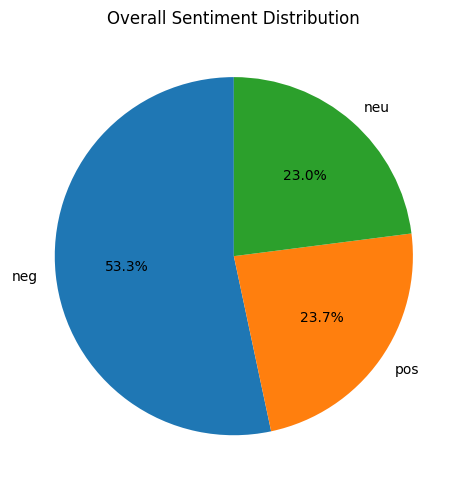

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


df_all = pd.concat([df_train, *test_dfs.values()], ignore_index=True)


counts = df_all["final_label"].value_counts()

plt.figure(figsize=(5, 5))
plt.pie(
    counts.values,
    labels=counts.index,
    autopct="%.1f%%",
    startangle=90
)
plt.title("Overall Sentiment Distribution")
plt.tight_layout()
plt.show()


In [ ]:
!pip -q install jieba wordcloud


In [ ]:
!ls /usr/share/fonts/truetype/


humor-sans  liberation


In [ ]:
!ls /usr/share/fonts/truetype/*/


/usr/share/fonts/truetype/humor-sans/:
Humor-Sans.ttf

/usr/share/fonts/truetype/liberation/:
LiberationMono-BoldItalic.ttf	     LiberationSansNarrow-Bold.ttf
LiberationMono-Bold.ttf		     LiberationSansNarrow-Italic.ttf
LiberationMono-Italic.ttf	     LiberationSansNarrow-Regular.ttf
LiberationMono-Regular.ttf	     LiberationSans-Regular.ttf
LiberationSans-BoldItalic.ttf	     LiberationSerif-BoldItalic.ttf
LiberationSans-Bold.ttf		     LiberationSerif-Bold.ttf
LiberationSans-Italic.ttf	     LiberationSerif-Italic.ttf
LiberationSansNarrow-BoldItalic.ttf  LiberationSerif-Regular.ttf


In [ ]:
import re
import jieba

#停用词表
stopwords = set("""
的 了 和 是 就 都 也 还 很 在 有 没有 不 是的 不是 但是 因为 所以 如果 这个 那个 这样 那样
一个 一种 这些 那些 我 你 他 她 它 我们 你们 他们 自己 大家 人 时候 现在 觉得 真的
会 能 可以 需要 应该 可能 还是 还有 其实 发生 看到 听说
""".split())


def clean_and_cut(text):
    text = str(text)

    text = re.sub(r"[^\u4e00-\u9fff]+", " ", text)
    words = jieba.lcut(text)

    words = [w for w in words if (len(w) >= 2 and w not in stopwords)]
    return words

pos_texts = df_all[df_all["final_label"] == "pos"]["text"].astype(str)

pos_words = []
for t in pos_texts:
    pos_words.extend(clean_and_cut(t))

pos_text = " ".join(pos_words)

print("pos words (after filtering):", len(pos_words))
print("example:", pos_words[:30])


pos words (after filtering): 10957
example: ['我要', '幸福', '一生', '你好', '魅力', '思想', '思考', '女性', '魅力', '太对', '筛选', '机制', '超高', '遨游', '苍穹', '一起', '遨游', '世界', '遇到', '事情', '一起', '商量', '解决', '双方', '真爱', '每天', '一起', '一起', '幸福', '好处']


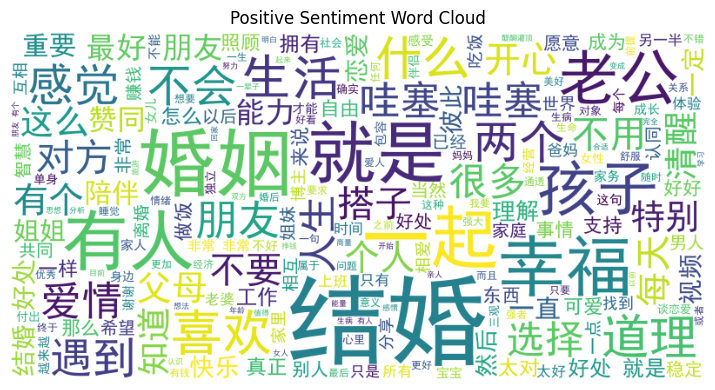

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import os

FONT_PATH = "/content/simhei.ttf"
assert os.path.exists(FONT_PATH), "找不到字体文件：/data/simhei.ttf"


wc_pos = WordCloud(
    font_path=FONT_PATH,
    width=800,
    height=400,
    background_color="white"
)

plt.figure(figsize=(8, 4))
plt.imshow(wc_pos.generate(pos_text))
plt.axis("off")
plt.title("Positive Sentiment Word Cloud")
plt.tight_layout()
plt.show()

In [ ]:
import jieba


neg_texts = df_all[df_all["final_label"] == "neg"]["text"].astype(str)

neg_words = []
for t in neg_texts:
    neg_words.extend(jieba.lcut(t))

neg_text = " ".join(neg_words)

print("负面文本长度：", len(neg_text))


负面文本长度： 180424


In [ ]:
stopwords_neg = set("""
的 了 和 是 就 都 也 还 很 在 有 没 不 不是
可以 不能 能 会 要 不要
一个 一种 这些 那些 这样 那样 这种
我 你 他 她 它 我们 你们 他们
现在 以后 之前 已经 觉得 感觉 认为
如果 因为 所以 但是 而且 然后
什么 怎么 为什么 哪个
这样 那个 这个
""".split())


In [ ]:
stopwords_neg.update("""
结婚 婚姻 婚后 离婚
就是 这样 那么 还是 可能 真的
不要 不想 不会 没有 不是
一个 两个 这种 那种
""".split())


In [ ]:
import re
import jieba

def clean_and_cut_neg(text):
    text = str(text)

    text = re.sub(r"[^\u4e00-\u9fff]+", " ", text)
    words = jieba.lcut(text)

    words = [
        w for w in words
        if len(w) >= 2 and w not in stopwords_neg
    ]
    return words

neg_texts = df_all[df_all["final_label"] == "neg"]["text"].astype(str)

neg_words = []
for t in neg_texts:
    neg_words.extend(clean_and_cut_neg(t))

neg_text = " ".join(neg_words)

print("neg words after filtering:", len(neg_words))
print("example:", neg_words[:30])


neg words after filtering: 25815
example: ['缺失', '抽身', '离开', '勇气', '我长', '这么', '遇到', '糟糕', '普通', '朋友', '共度', '一生', '可怕', '找个', '正常人', '太难', '这么', '人人', '有些', '跳脚', '越来越', '拐卖', '年轻', '女孩', '偏远', '山区', '延续', '后代', '甚至', '出现']


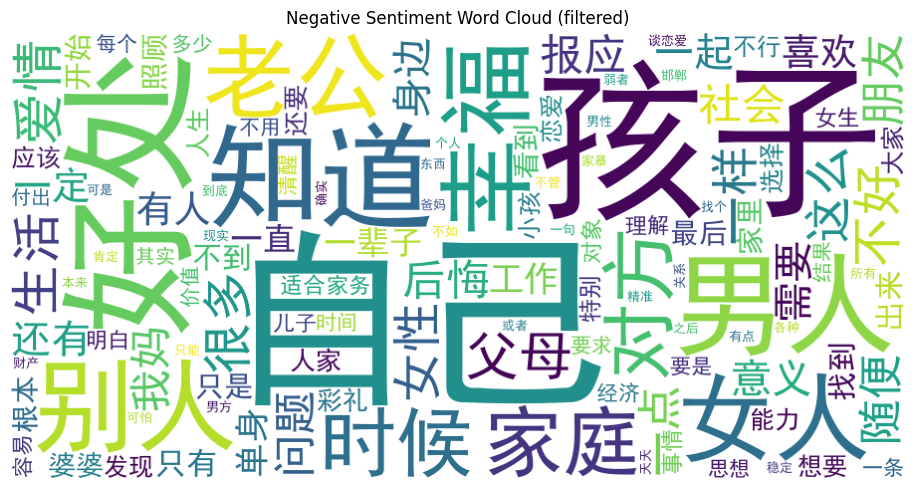

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

FONT_PATH = "/content/simhei.ttf"
assert os.path.exists(FONT_PATH), "找不到字体文件：/data/simhei.ttf"


wc_neg = WordCloud(
    font_path=FONT_PATH,
    width=900,
    height=450,
    background_color="white",
    max_words=120,
    collocations=False,
    min_word_length=2
)

plt.figure(figsize=(10, 5))
plt.imshow(wc_neg.generate(neg_text))
plt.axis("off")
plt.title("Negative Sentiment Word Cloud (filtered)")
plt.tight_layout()
plt.show()
